## Import Libraries

In [1]:
import os
from functools import reduce

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, ttest_ind
from adjustText import adjust_text
from Bio import PDB


## Replace this with your own path
PROJECT_DIR="/data1/lareauc/users/chuh/ProteinDesign/AdaptyvBio/egfr_neutralisation_analysis"
pd.set_option('display.max_columns', 500)

## Merge the dataframes for the analysis

In [2]:
destress_df = pd.read_csv(os.path.join(PROJECT_DIR,"data","tables","foldseek_adaptyv_destress_binder_merged.tsv"),sep="\t")
neutralisation_df = pd.read_csv(os.path.join(PROJECT_DIR,"data","tables","neutralisation_coefficient.csv"))
interchain_df = pd.read_csv(os.path.join(PROJECT_DIR,"data","tables","interchain_residue_indices.csv"))
egf_tmscore_df = pd.read_csv(os.path.join(PROJECT_DIR,"data","tables","tmscores_to_egf.csv"))
egf_tmscore_df = egf_tmscore_df.rename(columns={"tm_score":"EGF_tm_score"})

neutralisation_df_merged = reduce(lambda left, right: pd.merge(left, right, on='name',how="left"), [destress_df,neutralisation_df,interchain_df,egf_tmscore_df])
neutralisation_df_merged.index = neutralisation_df_merged["name"]
neutralisation_df_merged.head()


,common_id,query_swissprot,target_swissprot,fident_swissprot,alnlen_swissprot,mismatch_swissprot,gapopen_swissprot,qstart_swissprot,qend_swissprot,tstart_swissprot,tend_swissprot,evalue_swissprot,bits_swissprot,alntmscore_swissprot,qtmscore_swissprot,ttmscore_swissprot,lddt_swissprot,lddtfull_swissprot,prob_swissprot,query_pdb,target_pdb,fident_pdb,alnlen_pdb,mismatch_pdb,gapopen_pdb,qstart_pdb,qend_pdb,tstart_pdb,tend_pdb,evalue_pdb,bits_pdb,alntmscore_pdb,qtmscore_pdb,ttmscore_pdb,lddt_pdb,lddtfull_pdb,prob_pdb,username,name,kd,binding_strength,binding,expression,sequence,dna,pae_interaction,esm_pll,iptm,plddt,similarity_check,design_models,design_name_x,file_name,full_sequence,dssp_assignment,composition_ALA,composition_CYS,composition_ASP,composition_GLU,composition_PHE,composition_GLY,composition_HIS,composition_ILE,composition_LYS,composition_LEU,composition_MET,composition_ASN,composition_PRO,composition_GLN,composition_ARG,composition_SER,composition_THR,composition_VAL,composition_TRP,composition_UNK,composition_TYR,ss_prop_alpha_helix,ss_prop_beta_bridge,ss_prop_beta_strand,ss_prop_3_10_helix,ss_prop_pi_helix,ss_prop_hbonded_turn,ss_prop_bend,ss_prop_loop,isoelectric_point,charge,mass,num_residues,packing_density,aggrescan3d_avg_value,aggrescan3d_min_value,aggrescan3d_max_value,hydrophobic_fitness_per_aa,budeff_total_per_aa,budeff_steric_per_aa,budeff_desolvation_per_aa,budeff_charge_per_aa,evoef2_total_per_aa,evoef2_ref_total_per_aa,evoef2_intraR_total_per_aa,evoef2_interS_total_per_aa,evoef2_interD_total_per_aa,rosetta_total_per_aa,rosetta_fa_atr_per_aa,rosetta_fa_rep_per_aa,rosetta_fa_intra_rep_per_aa,rosetta_fa_elec_per_aa,rosetta_fa_sol_per_aa,rosetta_lk_ball_wtd_per_aa,rosetta_fa_intra_sol_xover4_per_aa,rosetta_hbond_lr_bb_per_aa,rosetta_hbond_sr_bb_per_aa,rosetta_hbond_bb_sc_per_aa,rosetta_hbond_sc_per_aa,rosetta_dslf_fa13_per_aa,rosetta_rama_prepro_per_aa,rosetta_p_aa_pp_per_aa,rosetta_fa_dun_per_aa,rosetta_omega_per_aa,rosetta_pro_close_per_aa,rosetta_yhh_planarity_per_aa,design_name_y,file_name_binder,full_sequence_binder,dssp_assignment_binder,composition_ALA_binder,composition_CYS_binder,composition_ASP_binder,composition_GLU_binder,composition_PHE_binder,composition_GLY_binder,composition_HIS_binder,composition_ILE_binder,composition_LYS_binder,composition_LEU_binder,composition_MET_binder,composition_ASN_binder,composition_PRO_binder,composition_GLN_binder,composition_ARG_binder,composition_SER_binder,composition_THR_binder,composition_VAL_binder,composition_TRP_binder,composition_UNK_binder,composition_TYR_binder,ss_prop_alpha_helix_binder,ss_prop_beta_bridge_binder,ss_prop_beta_strand_binder,ss_prop_3_10_helix_binder,ss_prop_pi_helix_binder,ss_prop_hbonded_turn_binder,ss_prop_bend_binder,ss_prop_loop_binder,isoelectric_point_binder,charge_binder,mass_binder,num_residues_binder,packing_density_binder,aggrescan3d_avg_value_binder,aggrescan3d_min_value_binder,aggrescan3d_max_value_binder,hydrophobic_fitness_per_aa_binder,budeff_total_per_aa_binder,budeff_steric_per_aa_binder,budeff_desolvation_per_aa_binder,budeff_charge_per_aa_binder,evoef2_total_per_aa_binder,evoef2_ref_total_per_aa_binder,evoef2_intraR_total_per_aa_binder,evoef2_interS_total_per_aa_binder,evoef2_interD_total_per_aa_binder,rosetta_total_per_aa_binder,rosetta_fa_atr_per_aa_binder,rosetta_fa_rep_per_aa_binder,rosetta_fa_intra_rep_per_aa_binder,rosetta_fa_elec_per_aa_binder,rosetta_fa_sol_per_aa_binder,rosetta_lk_ball_wtd_per_aa_binder,rosetta_fa_intra_sol_xover4_per_aa_binder,rosetta_hbond_lr_bb_per_aa_binder,rosetta_hbond_sr_bb_per_aa_binder,rosetta_hbond_bb_sc_per_aa_binder,rosetta_hbond_sc_per_aa_binder,rosetta_dslf_fa13_per_aa_binder,rosetta_rama_prepro_per_aa_binder,rosetta_p_aa_pp_per_aa_binder,rosetta_fa_dun_per_aa_binder,rosetta_omega_per_aa_binder,rosetta_pro_close_per_aa_binder,rosetta_yhh_planarity_per_aa_binder,neutralisation_coefficient,Chain_A_interface_residues,Chain_B_interface_residues,EGF_tm_score
name,,,,,,,,,,,,,,,,,,

## Set some constants


In [3]:
EGF_SEQ = neutralisation_df_merged.loc["Human_EGF","sequence"]
EGFR_SEQ = "LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPS"
EGF_KD = neutralisation_df_merged.loc["Human_EGF","kd"]
EGF_INTERFACE_RESIUDES = neutralisation_df_merged.loc["Human_EGF","Chain_B_interface_residues"]
EGF_INTERFACE_RESIUDES_SET = set(EGF_INTERFACE_RESIUDES.split(","))


## Compute the difference the set of residues engaged in the interface


In [4]:
def safe_set(x):
    if isinstance(x, str) and x.strip():
        return set(x.split(","))
    return None

def compute_jaccard_distance(set1, set2):
    if set1 is None or set2 is None:
        return None
    return 1 - len(set1 & set2) / len(set1 | set2)

def compute_intersection_size(set1, set2):
    if set1 is None or set2 is None:
        return None
    return len(set1 & set2)

def compute_set_diff_size(set1, set2):
    if set1 is None or set2 is None:
        return None
    return len(set1 - set2)

neutralisation_df_merged["EGF_interface_jaccard_distance"] = neutralisation_df_merged["Chain_B_interface_residues"].apply(lambda x: compute_jaccard_distance(safe_set(x), EGF_INTERFACE_RESIUDES_SET))
neutralisation_df_merged["EGF_interface_intersection"] = neutralisation_df_merged["Chain_B_interface_residues"].apply(lambda x: compute_intersection_size(safe_set(x), EGF_INTERFACE_RESIUDES_SET))
neutralisation_df_merged["EGF_interface_set_diff"] = neutralisation_df_merged["Chain_B_interface_residues"].apply(lambda x: compute_set_diff_size(safe_set(x), EGF_INTERFACE_RESIUDES_SET))
neutralisation_df_merged


,common_id,query_swissprot,target_swissprot,fident_swissprot,alnlen_swissprot,mismatch_swissprot,gapopen_swissprot,qstart_swissprot,qend_swissprot,tstart_swissprot,tend_swissprot,evalue_swissprot,bits_swissprot,alntmscore_swissprot,qtmscore_swissprot,ttmscore_swissprot,lddt_swissprot,lddtfull_swissprot,prob_swissprot,query_pdb,target_pdb,fident_pdb,alnlen_pdb,mismatch_pdb,gapopen_pdb,qstart_pdb,qend_pdb,tstart_pdb,tend_pdb,evalue_pdb,bits_pdb,alntmscore_pdb,qtmscore_pdb,ttmscore_pdb,lddt_pdb,lddtfull_pdb,prob_pdb,username,name,kd,binding_strength,binding,expression,sequence,dna,pae_interaction,esm_pll,iptm,plddt,similarity_check,design_models,design_name_x,file_name,full_sequence,dssp_assignment,composition_ALA,composition_CYS,composition_ASP,composition_GLU,composition_PHE,composition_GLY,composition_HIS,composition_ILE,composition_LYS,composition_LEU,composition_MET,composition_ASN,composition_PRO,composition_GLN,composition_ARG,composition_SER,composition_THR,composition_VAL,composition_TRP,composition_UNK,composition_TYR,ss_prop_alpha_helix,ss_prop_beta_bridge,ss_prop_beta_strand,ss_prop_3_10_helix,ss_prop_pi_helix,ss_prop_hbonded_turn,ss_prop_bend,ss_prop_loop,isoelectric_point,charge,mass,num_residues,packing_density,aggrescan3d_avg_value,aggrescan3d_min_value,aggrescan3d_max_value,hydrophobic_fitness_per_aa,budeff_total_per_aa,budeff_steric_per_aa,budeff_desolvation_per_aa,budeff_charge_per_aa,evoef2_total_per_aa,evoef2_ref_total_per_aa,evoef2_intraR_total_per_aa,evoef2_interS_total_per_aa,evoef2_interD_total_per_aa,rosetta_total_per_aa,rosetta_fa_atr_per_aa,rosetta_fa_rep_per_aa,rosetta_fa_intra_rep_per_aa,rosetta_fa_elec_per_aa,rosetta_fa_sol_per_aa,rosetta_lk_ball_wtd_per_aa,rosetta_fa_intra_sol_xover4_per_aa,rosetta_hbond_lr_bb_per_aa,rosetta_hbond_sr_bb_per_aa,rosetta_hbond_bb_sc_per_aa,rosetta_hbond_sc_per_aa,rosetta_dslf_fa13_per_aa,rosetta_rama_prepro_per_aa,rosetta_p_aa_pp_per_aa,rosetta_fa_dun_per_aa,rosetta_omega_per_aa,rosetta_pro_close_per_aa,rosetta_yhh_planarity_per_aa,design_name_y,file_name_binder,full_sequence_binder,dssp_assignment_binder,composition_ALA_binder,composition_CYS_binder,composition_ASP_binder,composition_GLU_binder,composition_PHE_binder,composition_GLY_binder,composition_HIS_binder,composition_ILE_binder,composition_LYS_binder,composition_LEU_binder,composition_MET_binder,composition_ASN_binder,composition_PRO_binder,composition_GLN_binder,composition_ARG_binder,composition_SER_binder,composition_THR_binder,composition_VAL_binder,composition_TRP_binder,composition_UNK_binder,composition_TYR_binder,ss_prop_alpha_helix_binder,ss_prop_beta_bridge_binder,ss_prop_beta_strand_binder,ss_prop_3_10_helix_binder,ss_prop_pi_helix_binder,ss_prop_hbonded_turn_binder,ss_prop_bend_binder,ss_prop_loop_binder,isoelectric_point_binder,charge_binder,mass_binder,num_residues_binder,packing_density_binder,aggrescan3d_avg_value_binder,aggrescan3d_min_value_binder,aggrescan3d_max_value_binder,hydrophobic_fitness_per_aa_binder,budeff_total_per_aa_binder,budeff_steric_per_aa_binder,budeff_desolvation_per_aa_binder,budeff_charge_per_aa_binder,evoef2_total_per_aa_binder,evoef2_ref_total_per_aa_binder,evoef2_intraR_total_per_aa_binder,evoef2_interS_total_per_aa_binder,evoef2_interD_total_per_aa_binder,rosetta_total_per_aa_binder,rosetta_fa_atr_per_aa_binder,rosetta_fa_rep_per_aa_binder,rosetta_fa_intra_rep_per_aa_binder,rosetta_fa_elec_per_aa_binder,rosetta_fa_sol_per_aa_binder,rosetta_lk_ball_wtd_per_aa_binder,rosetta_fa_intra_sol_xover4_per_aa_binder,rosetta_hbond_lr_bb_per_aa_binder,rosetta_hbond_sr_bb_per_aa_binder,rosetta_hbond_bb_sc_per_aa_binder,rosetta_hbond_sc_per_aa_binder,rosetta_dslf_fa13_per_aa_binder,rosetta_rama_prepro_per_aa_binder,rosetta_p_aa_pp_per_aa_binder,rosetta_fa_dun_per_aa_binder,rosetta_omega_per_aa_binder,rosetta_pro_close_per_aa_binder,rosetta_yhh_planarity_per_aa_binder,neutralisation_coefficient,Chain_A_interface_residues,Chain_B_interface_residues,EGF_tm_score,EGF_interface_jaccard_

## Filter to those for which neutralisation activities were measured

In [5]:
neutralisation_df_filtered = neutralisation_df_merged.dropna(subset=["neutralisation_coefficient"]).copy()
## Discretize neutralisation activity into bins
neutralisation_df_filtered["neutralisation_coefficient_bins"] = pd.cut(neutralisation_df_filtered["neutralisation_coefficient"],bins=[-0.01,0,0.2,0.8,1],labels=["none","weak","medium","strong"])
## Represent kd as fold affinity over native EGF affinity 
neutralisation_df_filtered["kd_EGF_normalized"] = EGF_KD/neutralisation_df_filtered["kd"]
len(neutralisation_df_filtered)

53

## Assign design type
The condition used here is by no mean the most generalized way to classify binder strucutres. They just so happen to assign each binder as to our expectation after manual inspection


In [6]:
## Winner sequences are taken from here:
## https://github.com/adaptyvbio/egfr_competition_1/blob/main/results/result_summary.csv

round1_winner_seq1 = "SPFDLFLDRLPEQDPEMTEEGKWWAEEMKRMVGPHFEELEEYIRNNASGEELETQLWTFLIIFDSMSKIVKRYASEETRKLLDELVKKIEEAIREAEEKAKSEEEKKELMRKVGIEVIKTLAELAEVDYKVPGIDYSF"
round1_winner_seq2 = "SAGQAQIEEVKARADKAKTLEELKELRKEAYEKNWKAYMAVVDETEKKIAEAKATGKGDLDKISEEGNNALQANQNTYLEQWDIIDEKAKELRAAEEAAK"

neutralisation_df_filtered["design_type"] = "unassigned"
neutralisation_df_filtered.loc[neutralisation_df_filtered["design_models"].isin(['["BindCraft"]','["RFdiffusion","ProteinMPNN/LigandMPNN"]']),"design_type"] = "de novo"
neutralisation_df_filtered.loc[neutralisation_df_filtered["EGF_tm_score"]>=0.7,"design_type"] = "EGF-like"
neutralisation_df_filtered.loc[neutralisation_df_filtered["sequence"].str.contains(f"{round1_winner_seq1}|{round1_winner_seq2}"),"design_type"] = "round1 combo"
neutralisation_df_filtered.loc[neutralisation_df_filtered["name"].str.contains("scFV|scfv|round1zeroshot|Fv-like"),"design_type"] = "scFV-like"
neutralisation_df_filtered.loc[neutralisation_df_filtered["name"].str.contains("nano|nAb"),"design_type"] = "nanobody-like"
neutralisation_df_filtered

,common_id,query_swissprot,target_swissprot,fident_swissprot,alnlen_swissprot,mismatch_swissprot,gapopen_swissprot,qstart_swissprot,qend_swissprot,tstart_swissprot,tend_swissprot,evalue_swissprot,bits_swissprot,alntmscore_swissprot,qtmscore_swissprot,ttmscore_swissprot,lddt_swissprot,lddtfull_swissprot,prob_swissprot,query_pdb,target_pdb,fident_pdb,alnlen_pdb,mismatch_pdb,gapopen_pdb,qstart_pdb,qend_pdb,tstart_pdb,tend_pdb,evalue_pdb,bits_pdb,alntmscore_pdb,qtmscore_pdb,ttmscore_pdb,lddt_pdb,lddtfull_pdb,prob_pdb,username,name,kd,binding_strength,binding,expression,sequence,dna,pae_interaction,esm_pll,iptm,plddt,similarity_check,design_models,design_name_x,file_name,full_sequence,dssp_assignment,composition_ALA,composition_CYS,composition_ASP,composition_GLU,composition_PHE,composition_GLY,composition_HIS,composition_ILE,composition_LYS,composition_LEU,composition_MET,composition_ASN,composition_PRO,composition_GLN,composition_ARG,composition_SER,composition_THR,composition_VAL,composition_TRP,composition_UNK,composition_TYR,ss_prop_alpha_helix,ss_prop_beta_bridge,ss_prop_beta_strand,ss_prop_3_10_helix,ss_prop_pi_helix,ss_prop_hbonded_turn,ss_prop_bend,ss_prop_loop,isoelectric_point,charge,mass,num_residues,packing_density,aggrescan3d_avg_value,aggrescan3d_min_value,aggrescan3d_max_value,hydrophobic_fitness_per_aa,budeff_total_per_aa,budeff_steric_per_aa,budeff_desolvation_per_aa,budeff_charge_per_aa,evoef2_total_per_aa,evoef2_ref_total_per_aa,evoef2_intraR_total_per_aa,evoef2_interS_total_per_aa,evoef2_interD_total_per_aa,rosetta_total_per_aa,rosetta_fa_atr_per_aa,rosetta_fa_rep_per_aa,rosetta_fa_intra_rep_per_aa,rosetta_fa_elec_per_aa,rosetta_fa_sol_per_aa,rosetta_lk_ball_wtd_per_aa,rosetta_fa_intra_sol_xover4_per_aa,rosetta_hbond_lr_bb_per_aa,rosetta_hbond_sr_bb_per_aa,rosetta_hbond_bb_sc_per_aa,rosetta_hbond_sc_per_aa,rosetta_dslf_fa13_per_aa,rosetta_rama_prepro_per_aa,rosetta_p_aa_pp_per_aa,rosetta_fa_dun_per_aa,rosetta_omega_per_aa,rosetta_pro_close_per_aa,rosetta_yhh_planarity_per_aa,design_name_y,file_name_binder,full_sequence_binder,dssp_assignment_binder,composition_ALA_binder,composition_CYS_binder,composition_ASP_binder,composition_GLU_binder,composition_PHE_binder,composition_GLY_binder,composition_HIS_binder,composition_ILE_binder,composition_LYS_binder,composition_LEU_binder,composition_MET_binder,composition_ASN_binder,composition_PRO_binder,composition_GLN_binder,composition_ARG_binder,composition_SER_binder,composition_THR_binder,composition_VAL_binder,composition_TRP_binder,composition_UNK_binder,composition_TYR_binder,ss_prop_alpha_helix_binder,ss_prop_beta_bridge_binder,ss_prop_beta_strand_binder,ss_prop_3_10_helix_binder,ss_prop_pi_helix_binder,ss_prop_hbonded_turn_binder,ss_prop_bend_binder,ss_prop_loop_binder,isoelectric_point_binder,charge_binder,mass_binder,num_residues_binder,packing_density_binder,aggrescan3d_avg_value_binder,aggrescan3d_min_value_binder,aggrescan3d_max_value_binder,hydrophobic_fitness_per_aa_binder,budeff_total_per_aa_binder,budeff_steric_per_aa_binder,budeff_desolvation_per_aa_binder,budeff_charge_per_aa_binder,evoef2_total_per_aa_binder,evoef2_ref_total_per_aa_binder,evoef2_intraR_total_per_aa_binder,evoef2_interS_total_per_aa_binder,evoef2_interD_total_per_aa_binder,rosetta_total_per_aa_binder,rosetta_fa_atr_per_aa_binder,rosetta_fa_rep_per_aa_binder,rosetta_fa_intra_rep_per_aa_binder,rosetta_fa_elec_per_aa_binder,rosetta_fa_sol_per_aa_binder,rosetta_lk_ball_wtd_per_aa_binder,rosetta_fa_intra_sol_xover4_per_aa_binder,rosetta_hbond_lr_bb_per_aa_binder,rosetta_hbond_sr_bb_per_aa_binder,rosetta_hbond_bb_sc_per_aa_binder,rosetta_hbond_sc_per_aa_binder,rosetta_dslf_fa13_per_aa_binder,rosetta_rama_prepro_per_aa_binder,rosetta_p_aa_pp_per_aa_binder,rosetta_fa_dun_per_aa_binder,rosetta_omega_per_aa_binder,rosetta_pro_close_per_aa_binder,rosetta_yhh_planarity_per_aa_binder,neutralisation_coefficient,Chain_A_interface_residues,Chain_B_interface_residues,EGF_tm_score,EGF_interface_jaccard_

In [7]:
neutralisation_df_filtered.to_csv(os.path.join(PROJECT_DIR,"data","tables","neutralisation_df_filtered.csv"),index=False)

# Analysis starts

## Define color palette for each category

In [8]:
DESIGN_TYPE_PALETTE = {
    "de novo": sns.color_palette("colorblind")[0],
    "EGF-like": sns.color_palette("colorblind")[1],
    "round1 combo": sns.color_palette("colorblind")[2],
    "scFV-like": sns.color_palette("colorblind")[3],
    "nanobody-like": sns.color_palette("colorblind")[4],
}

## What are the structural classes of the tested binders?

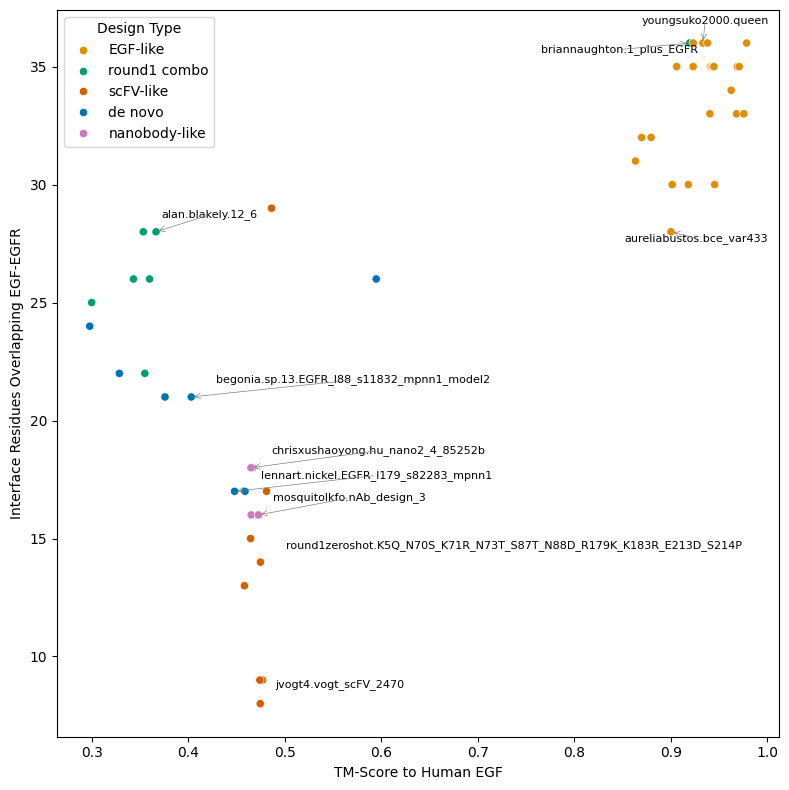

In [15]:
plot_df = neutralisation_df_filtered  # full scatter points
#plot_df["name_length"] = plot_df["name"].apply(lambda x: len(x))
# Pick subset to label
plot_df_label_subset = (
    neutralisation_df_filtered
    .sort_values('kd_EGF_normalized', ascending=False) #.sort_values('username_length', ascending=True)
    .drop_duplicates(subset=['design_type', 'username'])
    .groupby('design_type', group_keys=False)
    .head(2)
)

# Plot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=plot_df, x="EGF_tm_score", y="EGF_interface_intersection", hue="design_type",palette=DESIGN_TYPE_PALETTE)

# Label selected points
texts = []
for i, row in plot_df_label_subset.iterrows():
    texts.append(
        plt.text(
            row["EGF_tm_score"], 
            row["EGF_interface_intersection"], 
            str(row["name"]),  # Label text
            fontsize=8,
            ha='left',  # align text to left
            va='bottom'  # align text to bottom
        )
    )

# Adjust labels nicely
adjust_text(
    texts,
    expand_text=(2.0, 2.0),
    expand_points=(2.0, 2.0),
    force_text=(0.8, 0.8),
    force_points=(0.8, 0.8),
    arrowprops=dict(arrowstyle="->", color='gray', lw=0.5),
    only_move={'points': 'y', 'text': 'y'}  # allow only vertical moves (very important!)
)

# Final touches
plt.xlabel("TM-Score to Human EGF")
#plt.ylabel("|Binder-EGFR Interaface Residues ∩ EGF-EGFR Interface Residues|")
plt.ylabel("Interface Residues Overlapping EGF-EGFR")

plt.legend(title="Design Type")
plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DIR,"figures","binder_egf_tmscore_to_interface_overlap.pdf"),dpi=300)
plt.show()


## Do EGF-like binders bind like EGF?

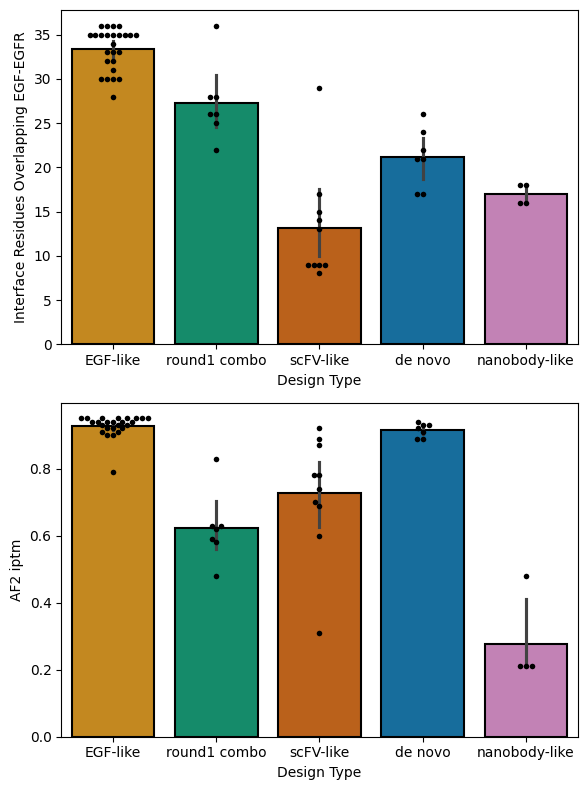

In [14]:
def plot_bar_swarm_with_pvalue(df, x_col, y_col, xlabel=None, ylabel=None, ax=None, palette=None):
    """
    Plot bar + swarmplot with colored bars based on a palette, black outlines, and orange dots.
    If `ax` is provided, plot inside the given axis (for multiple plots in one figure).

    Args:
        df (pd.DataFrame): Input dataframe
        x_col (str): Column name for x-axis (categorical variable)
        y_col (str): Column name for y-axis (numeric variable)
        xlabel (str, optional): Label for x-axis
        ylabel (str, optional): Label for y-axis
        ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis to plot into
        palette (dict, optional): Dictionary mapping categories to colors
    """
    plt.style.use('default')

    # If no axis provided, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # Barplot — **explicitly set hue to x_col**
    sns.barplot(
        data=df, 
        x=x_col, 
        y=y_col, 
        hue=x_col,
        palette=palette,
        edgecolor='black',
        linewidth=1.5,
        ax=ax,
        dodge=False,  # Important: don't separate bars into multiple groups
        legend=False  # Hide duplicate legends
    )

    # Swarmplot
    sns.swarmplot(
        data=df, 
        x=x_col, 
        y=y_col, 
        color='black',
        size=4,
        ax=ax
    )

    # Labels
    ax.set_xlabel(xlabel if xlabel else x_col)
    ax.set_ylabel(ylabel if ylabel else y_col)

    # Optional: make layout tight if stand-alone plot
    if ax is None:
        plt.tight_layout()
        plt.show()

fig, axes = plt.subplots(2, 1, figsize=(6, 8))  # 1 row, 2 columns
plot_bar_swarm_with_pvalue(neutralisation_df_filtered,"design_type","EGF_interface_intersection","Design Type","Interface Residues Overlapping EGF-EGFR",ax=axes[0],palette=DESIGN_TYPE_PALETTE)
plot_bar_swarm_with_pvalue(neutralisation_df_filtered,"design_type","iptm","Design Type","AF2 iptm",ax=axes[1],palette=DESIGN_TYPE_PALETTE)
#plot_bar_swarm_with_pvalue(neutralisation_df_filtered,"design_type","length","Design Type","kd",ax=axes[2])
#plot_bar_swarm_with_pvalue(neutralisation_df_filtered[neutralisation_df_filtered["kd_EGF_normalized"]>1],"design_type","neutralisation_coefficient","Design Type","Neutralisation Coeffcient",ax=axes[2])

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DIR,"figures","interface_and_iptm_by_design_type.pdf"),dpi=300)
plt.show()


## Which binders are the most successful at neutralising?

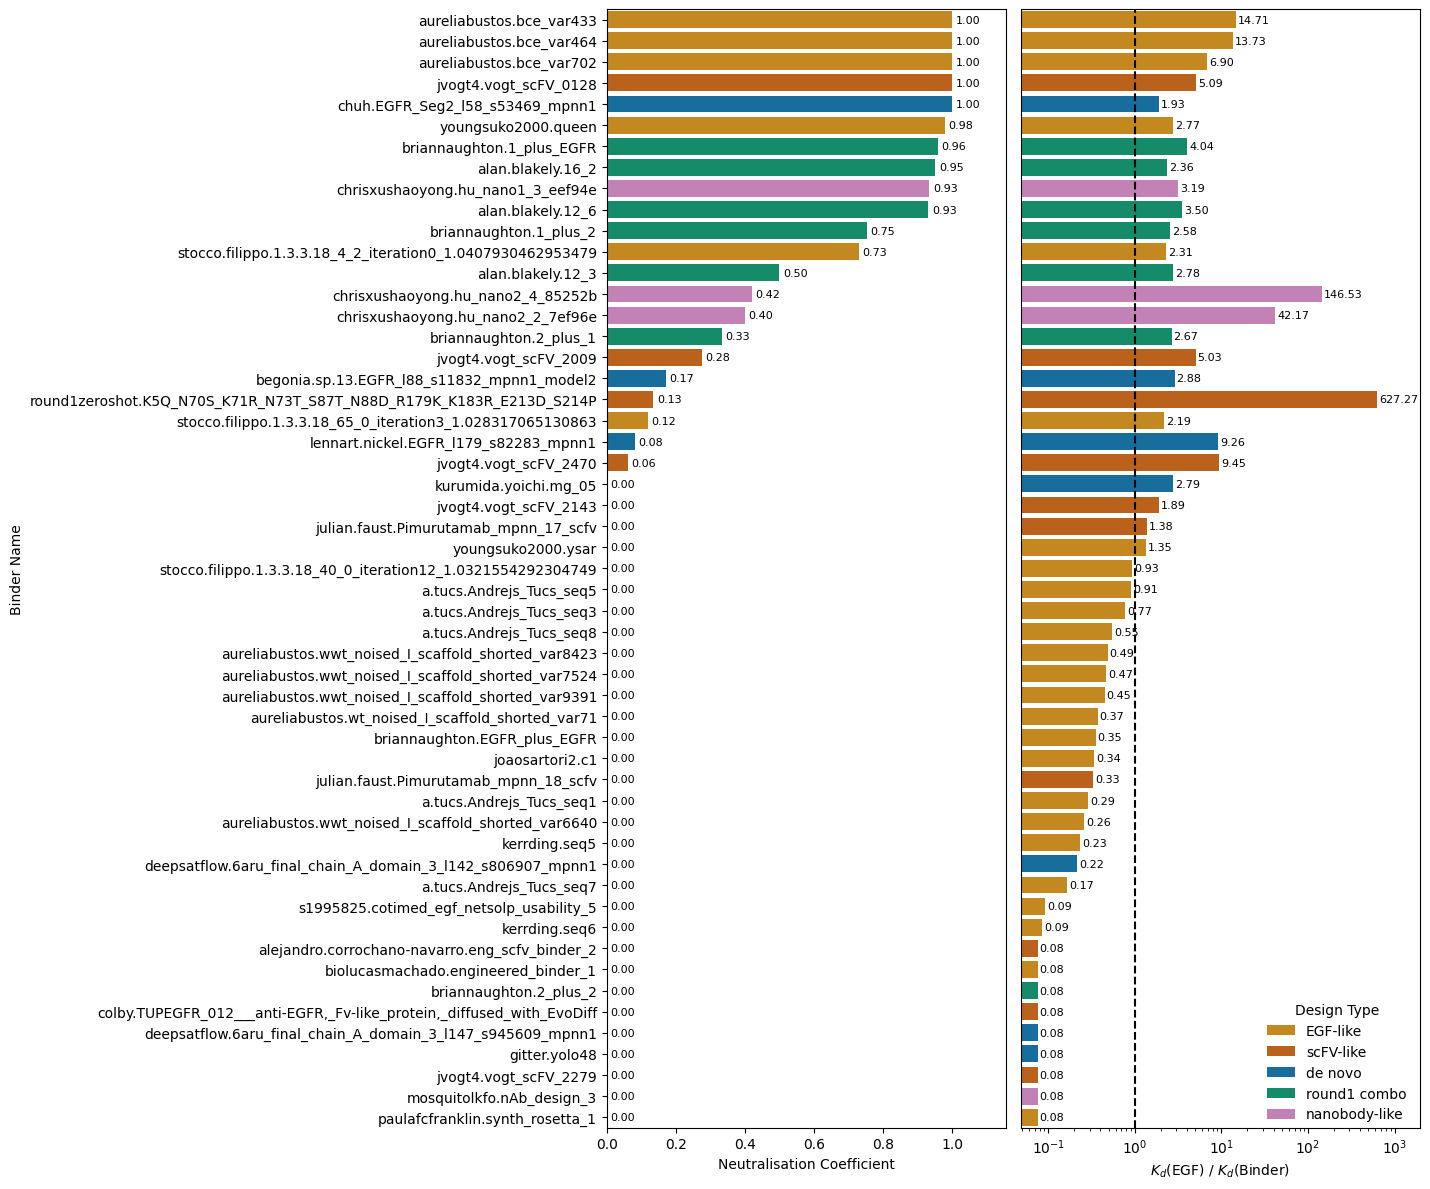

In [30]:
fig, axes = plt.subplots(figsize=(16, 12), ncols=2)

# Sort the dataframe
neutralisation_df_filtered_sorted = neutralisation_df_filtered.sort_values(
    by=["neutralisation_coefficient", "kd_EGF_normalized"], ascending=False
)

# First plot
sns.barplot(
    data=neutralisation_df_filtered_sorted,
    x="neutralisation_coefficient",
    y="name",
    hue="design_type",
    ax=axes[0],
    palette=DESIGN_TYPE_PALETTE,
    dodge=False
)
axes[0].set_ylabel("Binder Name")
axes[0].set_xlabel("Neutralisation Coefficient")

# Extend xlim for first plot
current_xlim = axes[0].get_xlim()
axes[0].set_xlim(current_xlim[0], current_xlim[1] * 1.1)  # extend by 10%

# Add value labels for first plot
for i, row in neutralisation_df_filtered_sorted.iterrows():
    axes[0].text(
        row["neutralisation_coefficient"] + (current_xlim[1] * 0.01),  # tiny offset right
        i,
        f"{row['neutralisation_coefficient']:.2f}",
        va='center',
        ha='left',
        fontsize=8
    )

# Second plot
sns.barplot(
    data=neutralisation_df_filtered_sorted,
    x="kd_EGF_normalized",
    y="name",
    hue="design_type",
    ax=axes[1],
    palette=DESIGN_TYPE_PALETTE,
    dodge=False
)
axes[1].set_xscale("log")
axes[1].set_xlabel("$K_d$(EGF) / $K_d$(Binder)")
axes[1].axvline(1, color="black", linestyle="--")

# Hide y-axis labels and ticks on the second plot
axes[1].set_ylabel("")
axes[1].set_yticklabels([])
axes[1].tick_params(axis='y', which='both', left=False)

# Extend xlim for second plot (log scale)
current_xlim = axes[1].get_xlim()
axes[1].set_xlim(current_xlim[0], current_xlim[1] * 2)  # more space since log scale

# Add value labels for second plot
for i, row in neutralisation_df_filtered_sorted.iterrows():
    axes[1].text(
        row["kd_EGF_normalized"] * 1.05,  # slight right offset
        i,
        f"{row['kd_EGF_normalized']:.2f}",
        va='center',
        ha='left',
        fontsize=8
    )

# Remove duplicate legends
axes[0].legend_.remove()
axes[1].legend_.remove()

# Create a single legend outside to the right
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles, 
    labels, 
    loc="lower right",
    bbox_to_anchor=(0.89,0.05),
    #loc='center right', 
    #bbox_to_anchor=(1, 0.5), 
    frameon=False,
    title="Design Type"
)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig(os.path.join(PROJECT_DIR,"figures","neutralisation_coefficient_ranking.pdf"),dpi=300)
plt.show()

## What is the relationship between Kd and neutralisation coefficient?

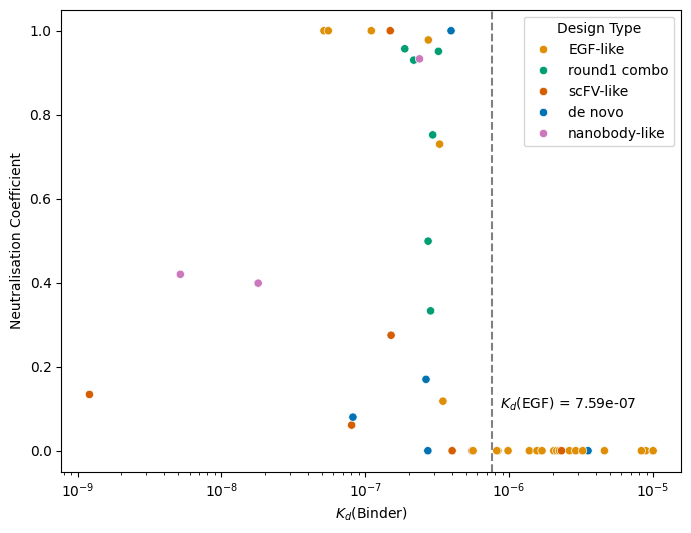

In [32]:
fig,ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=neutralisation_df_filtered,x="kd",y="neutralisation_coefficient",hue="design_type",palette=DESIGN_TYPE_PALETTE)
ax.axvline(x=EGF_KD,color="gray",linestyle="--")
ax.set_xscale("log")
ax.set_xlabel("$K_d$(Binder)")
ax.set_ylabel("Neutralisation Coefficient")
ax.text(EGF_KD+0.0000001,0.1,f"$K_d$(EGF) = {EGF_KD}")
sns.move_legend(ax,loc="upper right",title="Design Type")
fig.savefig(os.path.join(PROJECT_DIR,"figures","neutralisation_vs_kd.png.pdf"), dpi=300, bbox_inches="tight")

## What features correlate with neutralisation coefficient? Do they differ by binder structure? What if we only look at binders with higher affinity than EGF?

In [34]:
from scipy.stats import pearsonr, spearmanr, ttest_ind
def compute_df_correlations(df, outcome):
    correlations_outcomes = []
    float_metrics = [col for col in df.select_dtypes(include=["float"]).columns]
    
    for metric in float_metrics:
        outcome_data = df.dropna(subset=[metric, outcome])

        # Check if there are at least 2 data points
        if outcome_data.shape[0] < 2:
            print(f"Skipping {metric}: not enough valid data points.")
            continue
        try:
            outcome_pearson_corr, outcome_pearson_pval = pearsonr(outcome_data[metric], outcome_data[outcome])
            outcome_spearman_corr, outcome_spearman_pval = spearmanr(outcome_data[metric], outcome_data[outcome])
        except Exception as e:
            print(f"Skipping {metric} due to error: {e}")
            continue
        correlations_outcomes.append(
            {
                "metric": metric,
                "pearson_correlation": outcome_pearson_corr,
                "pearson_p_value": outcome_pearson_pval,
                "spearman_correlation": outcome_spearman_corr,
                "spearman_p_value": outcome_spearman_pval,
                "num_observations": len(outcome_data)
            }
        )
        
    correlation_df = pd.DataFrame(correlations_outcomes)
    return correlation_df
    
## Overall correlation
overall_correlation_df = compute_df_correlations(neutralisation_df_filtered,"neutralisation_coefficient")
overall_correlation_df["design_type"] = "all"

## Overall correlation (within each class)
overall_correlation_df_by_types = []
for design_type, sub_df in neutralisation_df_filtered.groupby("design_type"):
    sub_df_corr = compute_df_correlations(sub_df,"neutralisation_coefficient")
    sub_df_corr["design_type"] = design_type
    overall_correlation_df_by_types.append(sub_df_corr)
overall_correlation_per_class = pd.concat(overall_correlation_df_by_types,ignore_index=True)
overall_correlation_per_class

## Overall correlation (Binders that bind stronger than EGF only)
neutralisation_df_filtered_high_kd = neutralisation_df_filtered[neutralisation_df_filtered["kd_EGF_normalized"]>=1]
overall_high_kd_correlation_df = compute_df_correlations(neutralisation_df_filtered_high_kd,"neutralisation_coefficient")
overall_high_kd_correlation_df["design_type"] = "all ($K_d$(Binder) < EGF)"

## Overall correlation (Binders that bind stronger than EGF only, within each class)
overall_high_kd_correlation_df_by_types = []
for design_type, sub_df in neutralisation_df_filtered_high_kd.groupby("design_type"):
    sub_df_corr = compute_df_correlations(sub_df,"neutralisation_coefficient")
    sub_df_corr["design_type"] = f"{design_type} ($K_d$(Binder) < EGF)"
    overall_high_kd_correlation_df_by_types.append(sub_df_corr)
overall_high_kd_correlation_per_class = pd.concat(overall_high_kd_correlation_df_by_types,ignore_index=True)
overall_high_kd_correlation_per_class

## Combine all
combined_correlation_df = pd.concat([
    overall_correlation_df,overall_correlation_per_class,
    overall_high_kd_correlation_df,overall_high_kd_correlation_per_class
],ignore_index=True)
combined_correlation_df
combined_correlation_df.to_csv(os.path.join(PROJECT_DIR,"figures","correlations","combined_correlation_df.csv"))

#above_egf_binders = coef_df_filtered_merged[coef_df_filtered_merged["kd_egf_normalized"]>=1]
#correlation_df = compute_df_correlations(above_egf_binders,"neutralisation_coefficient")
#correlation_df

/tmp/ipykernel_1627368/1398456459.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  outcome_pearson_corr, outcome_pearson_pval = pearsonr(outcome_data[metric], outcome_data[outcome])
/tmp/ipykernel_1627368/1398456459.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  outcome_spearman_corr, outcome_spearman_pval = spearmanr(outcome_data[metric], outcome_data[outcome])
/tmp/ipykernel_1627368/1398456459.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  outcome_pearson_corr, outcome_pearson_pval = pearsonr(outcome_data[metric], outcome_data[outcome])
/tmp/ipykernel_1627368/1398456459.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  outcome_spearman_corr, outcome_spearman_pval = spearmanr(outcome_data[metric], outcome_data[outcome])
/tmp/ipykernel_1627368/1398456459.py:14: ConstantI

Skipping similarity_check: not enough valid data points.


/tmp/ipykernel_1627368/1398456459.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  outcome_pearson_corr, outcome_pearson_pval = pearsonr(outcome_data[metric], outcome_data[outcome])
/tmp/ipykernel_1627368/1398456459.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  outcome_spearman_corr, outcome_spearman_pval = spearmanr(outcome_data[metric], outcome_data[outcome])
/tmp/ipykernel_1627368/1398456459.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  outcome_pearson_corr, outcome_pearson_pval = pearsonr(outcome_data[metric], outcome_data[outcome])
/tmp/ipykernel_1627368/1398456459.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  outcome_spearman_corr, outcome_spearman_pval = spearmanr(outcome_data[metric], outcome_data[outcome])
/tmp/ipykernel_1627368/1398456459.py:14: ConstantI

Skipping similarity_check: not enough valid data points.


/tmp/ipykernel_1627368/1398456459.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  outcome_pearson_corr, outcome_pearson_pval = pearsonr(outcome_data[metric], outcome_data[outcome])
/tmp/ipykernel_1627368/1398456459.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  outcome_spearman_corr, outcome_spearman_pval = spearmanr(outcome_data[metric], outcome_data[outcome])
/tmp/ipykernel_1627368/1398456459.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  outcome_pearson_corr, outcome_pearson_pval = pearsonr(outcome_data[metric], outcome_data[outcome])
/tmp/ipykernel_1627368/1398456459.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  outcome_spearman_corr, outcome_spearman_pval = spearmanr(outcome_data[metric], outcome_data[outcome])
/tmp/ipykernel_1627368/1398456459.py:14: ConstantI

## Which subgroup has the most significant association between kd and neutralisation coefficient?

In [44]:
kd_neutralisation_corr_df

,metric,pearson_correlation,pearson_p_value,spearman_correlation,spearman_p_value,num_observations,design_type,neg_log_pval
30,kd,-0.466744,0.000427,-0.789840,2.067550e-12,53,all,11.684544
204,kd,-0.420621,0.036288,-0.748475,1.685263e-05,25,EGF-like,4.773332
378,kd,-0.388101,0.389617,-0.576551,1.754272e-01,7,de novo,0.755903
551,kd,-0.749530,0.250470,-0.400000,6.000000e-01,4,nanobody-like,0.221849
725,kd,-0.757623,0.048510,-0.535714,2.152175e-01,7,round1 combo,0.667123
899,kd,-0.364548,0.300345,-0.787989,6.782991e-03,10,scFV-like,2.168579


/tmp/ipykernel_1627368/3379314543.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


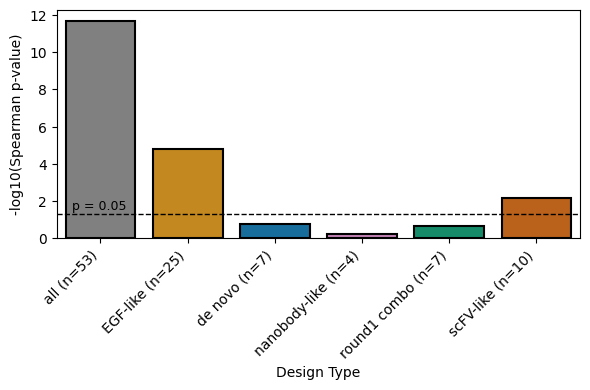

In [58]:
fig, ax = plt.subplots(figsize=(6, 4))

# Filter to just "kd" metric
kd_neutralisation_corr_df = combined_correlation_df[combined_correlation_df["metric"] == "kd"]
# Don't include the "Kd < EGF" subgroup
kd_neutralisation_corr_df = kd_neutralisation_corr_df[~kd_neutralisation_corr_df["design_type"].str.contains("< EGF")]
# Compute -log10(p-value)
kd_neutralisation_corr_df["neg_log_pval"] = -np.log10(kd_neutralisation_corr_df["spearman_p_value"])
# Create palette
plot_palette = DESIGN_TYPE_PALETTE.copy()
plot_palette["all"] = "gray"
# Create new x-tick labels combining design_type and number of observations
kd_neutralisation_corr_df["design_type_label"] = kd_neutralisation_corr_df.apply(
    lambda row: f"{row['design_type']} (n={row['num_observations']})", axis=1
)
# Plot
sns.barplot(
    data=kd_neutralisation_corr_df,
    x="design_type_label", 
    y="neg_log_pval",
    hue="design_type",
    palette=plot_palette,
    edgecolor='black',
    linewidth=1.5,
    ax=ax,
    legend=False
)

# Draw a horizontal dotted gray line at -log10(0.05)
pval_threshold = -np.log10(0.05)  # ~1.301
ax.axhline(y=pval_threshold, color="black", linestyle="--", linewidth=1)

# Annotate the threshold line
ax.text(
    0.3,  # slightly outside last bar
    pval_threshold + 0.1,  # slightly above the line
    "p = 0.05",
    color="black",
    ha="right",
    va="bottom",
    fontsize=9
)

# Rotate x-axis labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# Label axes
ax.set_ylabel("-log10(Spearman p-value)")
ax.set_xlabel("Design Type")

plt.tight_layout()
fig.savefig(os.path.join(PROJECT_DIR,"figures","design_subgroup_kd_neutralisation_spearman_pval.pdf"), dpi=300, bbox_inches="tight")
plt.show()

## Plot a heatmap of the significant correlated features in different subgroups

In [59]:
def plot_spearman_heatmap_with_significance(df, save_path, column_order=None):
    """
    Create and save a heatmap where:
    - Rows are 'metric'
    - Columns are 'design_type (n=observations)', optionally ordered
    - Values are 'spearman_correlation'
    - Cells are annotated with significance stars based on 'spearman_p_value'

    Args:
        df (pd.DataFrame): Input dataframe
        save_path (str): Full path to save the figure
        column_order (list, optional): List of 'design_type' to specify column order
    """

    # Get the number of observations per design_type
    design_type_counts = df.groupby('design_type')['num_observations'].max().to_dict()

    # Create new labels: "design_type (n=obs)"
    df = df.copy()
    df['design_type_label'] = df['design_type'].map(
        lambda x: f"{x} (n={design_type_counts.get(x, 'NA')})"
    )

    # Pivot tables
    corr_matrix = df.pivot(index='metric', columns='design_type_label', values='spearman_correlation')
    pval_matrix = df.pivot(index='metric', columns='design_type_label', values='spearman_p_value')

    # Optional: Reorder columns if a custom order is given
    if column_order is not None:
        column_label_order = [f"{col} (n={design_type_counts.get(col, 'NA')})" for col in column_order]
        corr_matrix = corr_matrix.reindex(columns=column_label_order)
        pval_matrix = pval_matrix.reindex(columns=column_label_order)

    # Create annotation matrix
    def annotate_corr(val, pval):
        if pd.isna(val):
            return ""
        if pval < 0.001:
            return "***"
        elif pval < 0.01:
            return "**"
        elif pval < 0.05:
            return "*"
        else:
            return ""

    annot_matrix = np.empty(corr_matrix.shape, dtype=object)
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            val = corr_matrix.iloc[i, j]
            pval = pval_matrix.iloc[i, j]
            annot_matrix[i, j] = annotate_corr(val, pval)

    # Plot
    plt.figure(figsize=(10, len(corr_matrix) * 0.5 + 2))
    sns.heatmap(
        corr_matrix,
        annot=annot_matrix,
        fmt="",
        cmap="vlag",
        center=0,
        cbar_kws={'label': 'Spearman Correlation'}
    )
    #plt.title(f"Spearman Correlation - {os.path.basename(save_path).replace('_', ' ').replace('.pdf', '').title()}", fontsize=14)
    plt.xlabel("Design Type")
    plt.ylabel("Metric")
    plt.tight_layout()

    # Make sure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.savefig(save_path)
    plt.close()
    print(f"Saved {save_path}")

## Visualize only metrics with at least one entry with p < 0.05
keep_metrics = combined_correlation_df[combined_correlation_df["spearman_p_value"]<0.05]["metric"].unique().tolist()
keep_metrics = [metric for metric in keep_metrics if "neutralisation" not in metric]
combined_correlation_df_trimmed = combined_correlation_df[combined_correlation_df["metric"].isin(keep_metrics)]

## For ease of visualisation we separate it into different dataframes
rosetta_metrics = [metric for metric in keep_metrics if "rosetta_" in metric]
composition_metrics = [metric for metric in keep_metrics if "composition_" in metric]
evoef2_metrics = [metric for metric in keep_metrics if "evoef2_" in metric]
ss_metrics = [metric for metric in keep_metrics if "ss_" in metric]
budeff_metrics = [metric for metric in keep_metrics if "budeff_" in metric]
aggrescan_metrics = [metric for metric in keep_metrics if "aggrescan3d_" in metric]
other_metrics = [metric for metric in keep_metrics if metric not in (rosetta_metrics+composition_metrics+evoef2_metrics+ss_metrics+budeff_metrics+aggrescan_metrics)]

## Subset the datafrmaes
combined_correlation_df_trimmed_rosetta = combined_correlation_df_trimmed[combined_correlation_df_trimmed["metric"].isin(rosetta_metrics)]
combined_correlation_df_trimmed_composition = combined_correlation_df_trimmed[combined_correlation_df_trimmed["metric"].isin(composition_metrics)]
combined_correlation_df_trimmed_evoef2 = combined_correlation_df_trimmed[combined_correlation_df_trimmed["metric"].isin(evoef2_metrics)]
combined_correlation_df_trimmed_ss = combined_correlation_df_trimmed[combined_correlation_df_trimmed["metric"].isin(ss_metrics)]
combined_correlation_df_trimmed_budeff = combined_correlation_df_trimmed[combined_correlation_df_trimmed["metric"].isin(budeff_metrics)]
combined_correlation_df_trimmed_aggrescan = combined_correlation_df_trimmed[combined_correlation_df_trimmed["metric"].isin(aggrescan_metrics)]
combined_correlation_df_trimmed_others = combined_correlation_df_trimmed[combined_correlation_df_trimmed["metric"].isin(other_metrics)]

# Column order you want (optional)
custom_column_order = [
    "all","EGF-like","de novo","round1 combo","scFV-like","nanobody-like",
    "all ($K_d$(Binder) < EGF)","EGF-like ($K_d$(Binder) < EGF)","de novo ($K_d$(Binder) < EGF)","round1 combo ($K_d$(Binder) < EGF)","scFV-like ($K_d$(Binder) < EGF)","nanobody-like ($K_d$(Binder) < EGF)",
]

# Plot them
corr_heatmap_save_dir = os.path.join(PROJECT_DIR,"figures","correlations")
plot_spearman_heatmap_with_significance(combined_correlation_df_trimmed_rosetta, os.path.join(corr_heatmap_save_dir,"rosetta_metrics_corr.pdf"),column_order=custom_column_order)
plot_spearman_heatmap_with_significance(combined_correlation_df_trimmed_composition, os.path.join(corr_heatmap_save_dir,"composition_metrics_corr.pdf"),column_order=custom_column_order)
plot_spearman_heatmap_with_significance(combined_correlation_df_trimmed_ss, os.path.join(corr_heatmap_save_dir,"ss_metrics_corr.pdf"),column_order=custom_column_order)
plot_spearman_heatmap_with_significance(combined_correlation_df_trimmed_evoef2, os.path.join(corr_heatmap_save_dir,"evoef2_metrics_corr.pdf"),column_order=custom_column_order)
plot_spearman_heatmap_with_significance(combined_correlation_df_trimmed_budeff, os.path.join(corr_heatmap_save_dir,"budeff_metrics_corr.pdf"),column_order=custom_column_order)
plot_spearman_heatmap_with_significance(combined_correlation_df_trimmed_aggrescan, os.path.join(corr_heatmap_save_dir,"aggrescan_metrics_corr.pdf"),column_order=custom_column_order)
plot_spearman_heatmap_with_significance(combined_correlation_df_trimmed_others, os.path.join(corr_heatmap_save_dir,"other_metrics_corr.pdf"),column_order=custom_column_order)



Saved /data1/lareauc/users/chuh/ProteinDesign/AdaptyvBio/egfr_neutralisation_analysis/figures/correlations/rosetta_metrics_corr.pdf
Saved /data1/lareauc/users/chuh/ProteinDesign/AdaptyvBio/egfr_neutralisation_analysis/figures/correlations/composition_metrics_corr.pdf
Saved /data1/lareauc/users/chuh/ProteinDesign/AdaptyvBio/egfr_neutralisation_analysis/figures/correlations/ss_metrics_corr.pdf
Saved /data1/lareauc/users/chuh/ProteinDesign/AdaptyvBio/egfr_neutralisation_analysis/figures/correlations/evoef2_metrics_corr.pdf
Saved /data1/lareauc/users/chuh/ProteinDesign/AdaptyvBio/egfr_neutralisation_analysis/figures/correlations/budeff_metrics_corr.pdf
Saved /data1/lareauc/users/chuh/ProteinDesign/AdaptyvBio/egfr_neutralisation_analysis/figures/correlations/aggrescan_metrics_corr.pdf
Saved /data1/lareauc/users/chuh/ProteinDesign/AdaptyvBio/egfr_neutralisation_analysis/figures/correlations/other_metrics_corr.pdf


## what are the most frequently contacted residues by binder class?

In [60]:
EGFR_LENGTH = 621 # This is the length of EGFR in the target structure
EGF_INTERFACE_RESIUDES_NUMS = [int(num[1:]) for num in EGF_INTERFACE_RESIUDES.split(",")]

def residues_to_arr(residue_str,chain_id="B",arr_length=EGFR_LENGTH):
    """
    Construct one-hot array using the residues indices list given
    """
    indices = residue_str.replace(chain_id,"").split(",")
    indices = [int(idx)+1 for idx in indices]
    arr = np.zeros(arr_length)
    arr[indices] += 1
    return arr.astype(int)

def make_frequency_df(df,onehot_col="Chain_B_onehot"):
    """
    Given a dataframe and its column containing numpy one hot columns, returns a new df with the index, count, and mean per position
    """
    count_arr = df[onehot_col].to_numpy().sum(axis=0)
    mean_arr = count_arr/df.shape[0]
    count_arr_df = pd.DataFrame({"residue_index":range(1,len(count_arr)+1),"count":count_arr,"mean":mean_arr})
    return count_arr_df

## Make a onehot array indicating the contacted residues on EGFR for each binder
neutralisation_df_filtered["Chain_B_onehot"] = neutralisation_df_filtered["Chain_B_interface_residues"].apply(residues_to_arr)

## Contact frequency of binders with neutralization coefficient > 0
neutralisation_df_filtered_nonzero_all = neutralisation_df_filtered[
    neutralisation_df_filtered["neutralisation_coefficient"] > 0
]
freq_df_nonzero_neutral_all = make_frequency_df(neutralisation_df_filtered_nonzero_all)
freq_df_nonzero_neutral_all["is_in_egf_interface"] = freq_df_nonzero_neutral_all["residue_index"].isin(EGF_INTERFACE_RESIUDES_NUMS)
freq_df_nonzero_neutral_all["EGFR_residue"] = freq_df_nonzero_neutral_all["residue_index"].apply(lambda x: f"{EGFR_SEQ[x-1]}{x}")
freq_df_nonzero_neutral_all

,residue_index,count,mean,is_in_egf_interface,EGFR_residue
0,1,0,0.0,False,L1
1,2,0,0.0,False,E2
2,3,0,0.0,False,E3
3,4,0,0.0,False,K4
4,5,0,0.0,False,K5
...,...,...,...,...,...
616,617,0,0.0,False,P617
617,618,0,0.0,False,K618
618,619,0,0.0,False,I619
619,620,0,0.0,False,P620


In [61]:
print(len(neutralisation_df_filtered_nonzero_all))

22


## Plot where the residues are on EGFR

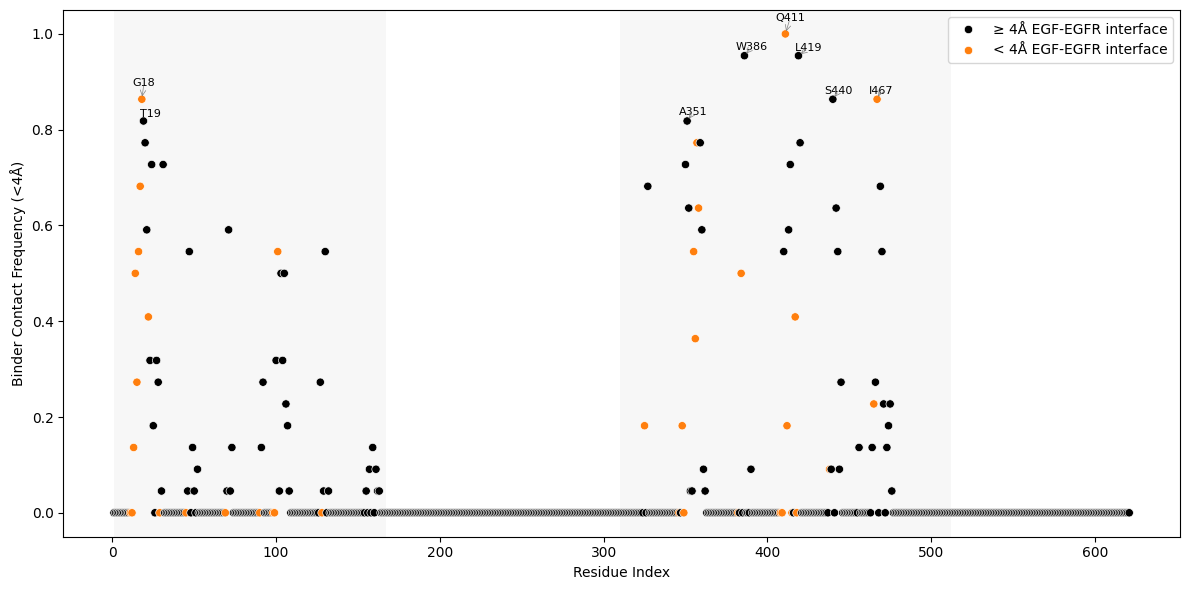

In [72]:
# Define a custom color palette
custom_palette = {
    True: "#ff7f0e",   # muted blue
    False: "black"   # muted orange
}

fig, ax = plt.subplots(figsize=(12,6))

# Main scatter plot
sns.scatterplot(
    data=freq_df_nonzero_neutral_all, 
    x="residue_index", 
    y="mean",
    hue="is_in_egf_interface",
    palette=custom_palette,
    ax=ax
)

# Manually set the legend
new_labels = {
    True: "< 4Å EGF-EGFR interface",
    False: "≥ 4Å EGF-EGFR interface"
}
handles, labels = ax.get_legend_handles_labels()
new_labels_list = [new_labels[eval(label)] for label in labels]  # labels are strings 'True'/'False', so eval
ax.legend(handles, new_labels_list, title="EGF-EGFR Interface", loc="upper right")

# Axis labels
ax.set_xlabel("Residue Index")
ax.set_ylabel("Binder Contact Frequency (<4Å)")

# Add alternating background
EGFR_DOMAIN_SPLITS = [1, 167, 310, 512]
add_alternating_background(ax, EGFR_DOMAIN_SPLITS)

# Label high points
label_high_points(
    ax, 
    df=freq_df_nonzero_neutral_all, 
    x_col="residue_index", 
    y_col="mean", 
    label_col="EGFR_residue",
    threshold=0.8
)

sns.move_legend(ax,loc="upper right",title="")

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DIR, "figures", "top_EGFR_interface_residues_by_binders_with_nonzero_neutralisation.pdf"), dpi=300)
plt.show()

## Write the contact frequency as bfactor in the PDB file for downstream visualization

In [622]:
def assign_bfactors_to_pdb(input_pdb_path, output_pdb_path, df, residue_col, value_col, chain_id="A"):
    """
    Create a new PDB file where residue B-factors are overwritten by specified values.

    Args:
        input_pdb_path (str): Path to original PDB file.
        output_pdb_path (str): Path to save modified PDB file.
        df (pd.DataFrame): DataFrame with residue numbers and values.
        residue_col (str): Column with residue numbers (1-based).
        value_col (str): Column with values.
        chain_id (str): Chain ID to target.
    """
    # Load structure
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("model", input_pdb_path)

    # Build a dictionary of residue number -> value
    value_map = dict(zip(df[residue_col], df[value_col]))

    # Iterate over residues and assign b-factors
    for model in structure:
        for chain in model:
            if chain.id != chain_id:
                continue
            for residue in chain:
                res_id = residue.get_id()[1]  # residue number
                if res_id in value_map:
                    for atom in residue:
                        atom.set_bfactor(float(value_map[res_id]))
                else:
                    # If residue not in dataframe, set to 0
                    for atom in residue:
                        atom.set_bfactor(0.0)

    # Save modified PDB
    io = PDB.PDBIO()
    io.set_structure(structure)
    io.save(output_pdb_path)

    print(f"Saved modified PDB with assigned B-factors to {output_pdb_path}")

EGFR_pdb = os.path.join(PROJECT_DIR,"data","extra_predictions","Human_EGF_chain_B_only.pdb")

assign_bfactors_to_pdb(
    EGFR_pdb,
    os.path.join(PROJECT_DIR,"data","pymol_bfactor_pdbs","Human_EGF_chain_B_only_nonzero_neutraliser_contact_frequency.pdb"),
    freq_df_nonzero_neutral_all,
    "residue_index",
    "mean",
    "B"
)



Saved modified PDB with assigned B-factors to /data1/lareauc/users/chuh/ProteinDesign/AdaptyvBio/egfr_neutralisation_analysis/data/pymol_bfactor_pdbs/Human_EGF_chain_B_only_nonzero_neutraliser_contact_frequency.pdb


## TODO: Make these plots later?

In [599]:
## Contact frequency by binders with neutralization coefficient (EGF-like)
neutralisation_df_filtered_nonzero_egf_like = neutralisation_df_filtered_nonzero_all[neutralisation_df_filtered_nonzero_all["design_type"]=="EGF-like"]
freq_df_nonzero_neutral_egf_like = make_frequency_df(neutralisation_df_filtered_nonzero_egf_like)

## Contact frequency by binders with neutralization coefficient (de novo)
neutralisation_df_filtered_nonzero_de_novo = neutralisation_df_filtered_nonzero_all[neutralisation_df_filtered_nonzero_all["design_type"]=="de novo"]
freq_df_nonzero_neutral_de_novo = make_frequency_df(neutralisation_df_filtered_nonzero_de_novo)

## Contact frequency by binders with neutralization coefficient (round 1 combo)
neutralisation_df_filtered_nonzero_r1_combo = neutralisation_df_filtered_nonzero_all[neutralisation_df_filtered_nonzero_all["design_type"]=="round1 combo"]
freq_df_nonzero_neutral_r1_combo = make_frequency_df(neutralisation_df_filtered_nonzero_r1_combo)

## Contact frequency by binders with neutralization coefficient (scFV-like)
neutralisation_df_filtered_nonzero_scFv_like = neutralisation_df_filtered_nonzero_all[neutralisation_df_filtered_nonzero_all["design_type"]=="scFV-like"]
freq_df_nonzero_neutral_scFv_like = make_frequency_df(neutralisation_df_filtered_nonzero_scFv_like)

## Contact frequency by binders with neutralization coefficient (nanobody-like)
neutralisation_df_filtered_nonzero_nAb_like = neutralisation_df_filtered_nonzero_all[neutralisation_df_filtered_nonzero_all["design_type"]=="nanobody-like"]
freq_df_nonzero_neutral_nAb_like = make_frequency_df(neutralisation_df_filtered_nonzero_nAb_like)


,residue_index,count,mean,is_in_egf_interface
10,11,0,0.000000,True
11,12,0,0.000000,True
97,98,0,0.000000,True
98,99,0,0.000000,True
89,90,0,0.000000,True
68,69,0,0.000000,True
44,45,0,0.000000,True
28,29,0,0.000000,True
381,382,0,0.000000,True
407,408,0,0.000000,True
